In [3]:
# This is an implementation of imp step based on Gorte paper 

In [52]:
# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from shapely.geometry import Point, LineString, Polygon

from algorithms import mm_utils
from Fuzzy.FIS1 import FIS1

# read data 
gdf = pd.read_pickle('envirocar.pkl')

# get road network 
# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox


# Download a map by specifying the bounding box
# and draw the graph
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive') #

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making th

+init=epsg:32631 +type=crs
GeoSeries([], Name: geometry, dtype: geometry)


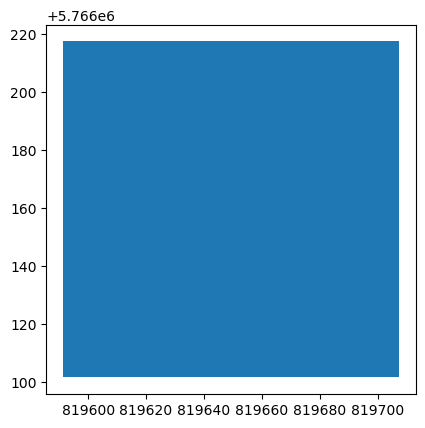

In [194]:
i = 5
initial_links = pd.DataFrame(columns=['V1', 'V2', 'edge_id', 'direction', 'NP_x', 'NP_y'])


# get position 
lon = gdf['geometry'].x[i]
lat = gdf['geometry'].y[i]
curr_point = np.array([lon, lat])

#----------------------------------------
# create error region as SpatialPolygon 
#----------------------------------------
# error size 
err_size = 58
# initialzie points 
# use utm for crs : 
UTMzone = (180 + 5) // 6 + 1
#crs_str = f"+proj=utm +zone={UTMzone} +ellps=WGS84 +datum=WGS84"
crs_str ="epsg:4326"

#change gdf to utm 31 projection 
locs = gpd.GeoDataFrame(geometry = gdf['geometry'], crs = crs_str)
locs_utm = locs.to_crs({'init': 'epsg:32631'})
print(locs_utm.crs)


# convert to geodataframe -- assign the CRS using epsg code 
curr_loc = gpd.GeoDataFrame(geometry = gpd.points_from_xy([lon], [lat]), crs=crs_str)

# convert ot UTM zone 31 which is equal to epsg32631 according to https://spatialreference.org/ref/epsg/32631/
curr_loc = curr_loc.to_crs({'init': 'epsg:32631'})
#print(curr_loc['geometry'])

x = curr_loc['geometry'].x[0]
y = curr_loc['geometry'].y[0]

# create rectangular polygon 
err_coord = [[x - err_size, y + err_size], 
             [x + err_size, y + err_size],
             [x + err_size, y - err_size],
             [x - err_size, y - err_size]]

poly_coord = Polygon(err_coord)
# #print(ply_coord)
df = {'Attribute' : ['name1'], 'geometry':poly_coord}

err_poly = gpd.GeoDataFrame(df, geometry = 'geometry', crs = "EPSG:32631")


#plot error polygon for debugging
err_poly.plot()

# extract road info 
nodes, edges = ox.graph_to_gdfs(G)

# project edges into UTM 31 projection 
edges_utm = edges.to_crs({'init': 'epsg:32631'})

#print(edges_utm)
#print(err_poly.crs)

# Check for intersection and containment using geopandas
intersects = gpd.sjoin(err_poly, edges_utm, op='intersects')
contains = gpd.sjoin(err_poly, edges_utm, op='contains')

# extract index from edges that intersect with error polygon 
int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
# extract index from edges that contained in the error polygon 
cont_index = contains[['index_right0', 'index_right1', 'index_right2']]

# merge index
index = pd.concat([int_index, cont_index])
# drop duplicate
index = index.drop_duplicates()

# initialize candidate edges 
appended_edge = []

# extract candidate eges  
for i in range(len(index)):
    edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
    appended_edge.append(edge_list)

candidate_link = edges.loc[appended_edge]

print(candidate_link['geometry'])



# Combine the indices from both operations
#id = list(set(intersects['osmid'] + contains['osmid']))

#print(intersects)
#print(contains)
#print(indices)
#print(candidate_link)

# Create the candidate_links data frame
#candidate_links = roads.iloc[indices][['edge_id']].reset_index(drop=True)

# Print the candidate_links data frame
#print(candidate_links)



In [191]:
type(candidate_link)


geopandas.geodataframe.GeoDataFrame

<class 'geopandas.geodataframe.GeoDataFrame'>


<Axes: >

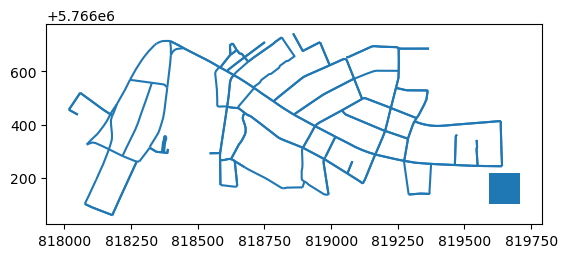

In [195]:
# This is how we  visualize edges and error bound 
#print(edges)
print(type(edges))

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm[0:13].plot(ax=ax)

#current location versus edges
#curr_loc.plot(ax=ax)

#err coord 
err_poly.plot(ax=ax)

# edges
edges_utm.plot(ax=ax)


#print(intersects['index_right'])

In [141]:
# extracting index of the intersect edges 
index = intersects[['index_right0', 'index_right1', 'index_right2']]

# extracting data from edges 
edges.loc[(53200191, 135535395, 0)]

for i in range(len(index)):
    print(edges.loc[(intersects['index_right0'].iloc[i], intersects['index_right1'].iloc[i], 0 )])

osmid                                  [673214248, 234046511]
lanes                                                       3
ref                                                     L 793
name                                         Wolbecker Straße
highway                                             secondary
maxspeed                                                   50
oneway                                                  False
reversed                                                 True
length                                                 54.889
geometry    LINESTRING (7.651807 51.9548654, 7.6518768 51....
width                                                     NaN
access                                                    NaN
Name: (53200191, 135535395, 0), dtype: object
osmid                                  [673214248, 234046511]
lanes                                                       3
ref                                                     L 793
name                    

In [137]:
# print(edges)
# edges.columns.values
#print(edges['osmid'])
for i, v in edges['osmid'].items():
    print(i)
# print(edges['osmid'].values)


# attr = dir(edges['osmid'])
# for x in attr:
#     print(x)
# print(edges['osmid'].loc["u"])


(21518865, 43601038, 0)
(21518866, 21518865, 0)
(21518867, 21518866, 0)
(21518867, 60358392, 0)
(21518872, 52774658, 0)
(21518875, 21518954, 0)
(21518875, 1631144426, 0)
(21518876, 21518867, 0)
(21518954, 60358392, 0)
(21518954, 42908014, 0)
(37513773, 42908014, 0)
(37514058, 41665100, 0)
(37514058, 42907801, 0)
(41665100, 2577185238, 0)
(41665100, 37514058, 0)
(42907691, 1504411732, 0)
(42907691, 314436395, 0)
(42907801, 2505759276, 0)
(42907801, 37514058, 0)
(42907801, 21518876, 0)
(42908014, 2505759277, 0)
(43599624, 52693568, 0)
(43599624, 6152925223, 0)
(43599624, 52139636, 0)
(43599624, 110368894, 0)
(43600642, 43602743, 0)
(43600642, 91718741, 0)
(43600642, 83679375, 0)
(43601038, 443003860, 0)
(43601038, 21518865, 0)
(43602117, 135535323, 0)
(43602117, 43602657, 0)
(43602657, 43602117, 0)
(43602743, 87259614, 0)
(43602743, 83679366, 0)
(43602743, 43600642, 0)
(51516875, 296965826, 0)
(51516875, 52726584, 0)
(51516875, 296965817, 0)
(51516875, 81331484, 0)
(52139612, 135535424, 

In [142]:
# Finding unique index from edges that interesct and edges that contained in the err polygon 
print(intersects)
print(contains)

  Attribute                                           geometry  index_right0  \
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200191   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535395   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200191   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200192   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535401   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535395   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...   10548918654   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   

   index_right1  index_right2                   osmid lanes    ref  \
0     135535395             0  [673214248, 234046

In [183]:
# extract index from edges that intersect with error polygon 
int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
# extract index from edges that contained in the error polygon 
cont_index = contains[['index_right0', 'index_right1', 'index_right2']]
#print(int_index)
#print(cont_index)

# merge index
index = pd.concat([int_index, cont_index])
# drop duplicate
index = index.drop_duplicates()
#print(index)

# initialize candidate edges 
appended_edge = []

# extract candidate eges  
for i in range(len(index)):
    edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
    appended_edge.append(edge_list)

print(appended_edge)

edges.loc[appended_edge]


[(53200191, 135535395, 0), (135535395, 53200191, 0), (53200191, 6152925224, 0), (6152925224, 53200191, 0), (6152925224, 53200192, 0), (53200192, 6152925224, 0), (135535401, 135535395, 0), (135535395, 135535401, 0), (10548918654, 6152925224, 0), (6152925224, 10548918654, 0)]


osmid lanes    ref  \
u           v           key                                        
53200191    135535395   0    [673214248, 234046511]     3  L 793   
135535395   53200191    0    [673214248, 234046511]     3  L 793   
53200191    6152925224  0                 470244584     3  L 793   
6152925224  53200191    0                 470244584     3  L 793   
            53200192    0    [673214250, 467653690]     2  L 793   
53200192    6152925224  0    [467653690, 673214250]     2  L 793   
135535401   135535395   0                  14180413     2    NaN   
135535395   135535401   0                  14180413     2    NaN   
10548918654 6152925224  0                  28961154   NaN    NaN   
6152925224  10548918654 0                  28961154   NaN    NaN   

                                             name      highway maxspeed  \
u           v           key                                               
53200191    135535395   0        Wolbecker Straße    secondary       50   
135535395   53200191    0        Wolbecker Straße    secondary       50   
53200191    6152925224  0        Wolbecker Straße    secondary       50   
6152925224  53200191    0        Wolbecker Straße    secondary       50   
            53200192    0        Wolbecker Straße    secondary       50   
53200192    6152925224  0        Wolbecker Straße    secondary       50   
135535401   135535395   0    Andreas-Hofer-Straße  residential      NaN   
135535395   135535401   0    Andreas-Hofer-Straße  residential      NaN   
10548918654 6152925224  0             Brunostraße  residential       30   
6152925224  10548918654 0             Brunostraße  residential       30   

                             oneway  reversed  length  \
u           v           key                             
53200191    135535395   0     False      True  54.889   
135535395   53200191    0     False     False  54.889   
53200191    6152925224  0     False     False  36.973   
6152925224  53200191    0     False      True  36.973   
            53200192    0     False     False  22.331   
53200192    6152925224  0     False      True  22.331   
135535401   135535395   0     False      True  80.186   
135535395   135535401   0     False     False  80.186   
10548918654 6152925224  0     False     False  97.885   
6152925224  10548918654 0     False      True  97.885   

                                                                      geometry  \
u           v           key                                                      
53200191    135535395   0    LINESTRING (7.65181 51.95487, 7.65188 51.95486...   
135535395   53200191    0    LINESTRING (7.65261 51.95483, 7.65247 51.95483...   
53200191    6152925224  0    LINESTRING (7.65181 51.95487, 7.65165 51.95487...   
6152925224  53200191    0    LINESTRING (7.65127 51.95489, 7.65157 51.95488...   
            53200192    0    LINESTRING (7.65127 51.95489, 7.65121 51.95489...   
53200192    6152925224  0    LINESTRING (7.65094 51.95491, 7.65121 51.95489...   
135535401   135535395   0    LINESTRING (7.65264 51.95555, 7.65263 51.95533...   
135535395   135535401   0    LINESTRING (7.65261 51.95483, 7.65261 51.95488...   
10548918654 6152925224  0    LINESTRING (7.65132 51.95577, 7.65131 51.95552...   
6152925224  10548918654 0    LINESTRING (7.65127 51.95489, 7.65128 51.95496...   

                            width access  
u           v           key               
53200191    135535395   0     NaN    NaN  
135535395   53200191    0     NaN    NaN  
53200191    6152925224  0     NaN    NaN  
6152925224  53200191    0     NaN    NaN  
            53200192    0     NaN    NaN  
53200192    6152925224  0     NaN    NaN  
135535401   135535395   0     NaN    NaN  
135535395   135535401   0     NaN    NaN  
10548918654 6152925224  0       3    NaN  
6152925224  10548918654 0       3    NaN